# Data cleaning

Redan i samband med introduktionen av Jupyter notebook gick vi igenom flera metoder för att städa upp data. Vi kontrollerade t.ex. att datatyper var rätt och omvandlade dessa i de fall de var fel, och vi rensade bort data som vi inte ville ha med från vår dataframe. Det vi inte gick igenom var hur man kan fylla ut data i de fall som data saknas för t.ex. en tidsserie. Här tittar vi på ett antal alternativa metoder; *ffill*, *bfill*, samt *interpolate*. Vi utgår från vår fil oil.csv från inlämningsuppgift och läser in den från Github: 

In [7]:
import pandas as pd
oil = pd.read_csv('https://raw.githubusercontent.com/hornstein/multichannel-analytics/master/data/oil.csv')
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


Låt oss kontrollera datatyperna:

In [8]:
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null object
dcoilwtico    1175 non-null float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


Vi ser att *date* har typen *object* och kan fixa till detta genom att göra om den till ett datum-format:

In [9]:
oil['date'] =  pd.to_datetime(oil['date'])
oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
date          1218 non-null datetime64[ns]
dcoilwtico    1175 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.2 KB


In [10]:
oil['date'].min()

Timestamp('2013-01-01 00:00:00')

Det saknas också rader för en del datum. Vi kan skapa upp en datum-range som innehåller samtliga rader med följande kommando:

In [11]:
all_days = pd.date_range(oil['date'].min(), oil['date'].max(), freq='D')
print(all_days)

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2017-08-22', '2017-08-23', '2017-08-24', '2017-08-25',
               '2017-08-26', '2017-08-27', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', length=1704, freq='D')


Vi kan sedan lägga in denna i en dataframe:

In [12]:
df = pd.DataFrame(all_days, columns = ['date'])
df.head()

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05


Nu har vi en komplett date-range, men vi har ingen data för vårt oljepris-index. Detta kan vi få genom att göra en merge med vår dataframe *oil*:

In [13]:
df=pd.merge(df, oil, on='date', how='left')
df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,NaN


Vi ser att denna innehåller en del rader med värdet NaN. För att få en bättre bild av detta kan vi plotta vår dataframe:

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


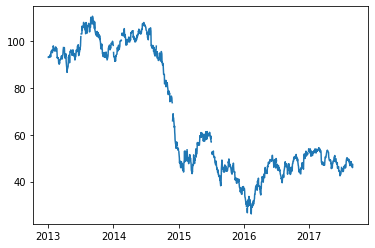

In [14]:
import matplotlib.pyplot as plt
plt.plot(oil['date'], oil['dcoilwtico'])

Lått oss använda *ffill* för att fylla ut de värden som saknas. Ffill fyller i alla NaN-celler med föregående cells värde. I vårt fall fungerar detta för samtliga utom det första värdet eftersom vi då inte har något föregående värde att hämta data från: 

In [15]:
oil_ffill=df.fillna(method='ffill')
oil_ffill.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.12


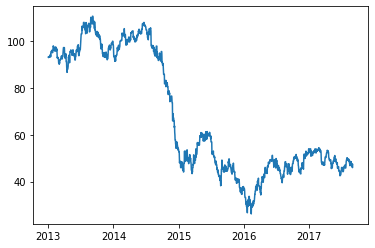

In [16]:
plt.plot(oil_ffill['date'], oil_ffill['dcoilwtico'])

Alternativet är att göra en backfill, *bfill*, d.v.s. att istället börja från botten och fylla i uppåt. Genom att först göra en *ffill* följt av en *bfill* garanterar vi att vi har värden för samtliga celler:

In [17]:
oil_bfill=df.fillna(method='bfill')
oil_bfill.head()

,date,dcoilwtico
0,2013-01-01,93.14
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-05,93.20


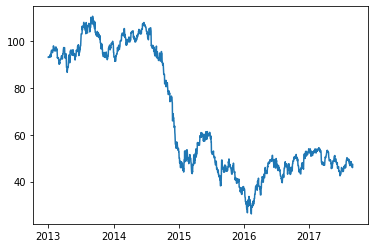

In [18]:
plt.plot(oil_bfill['date'], oil_bfill['dcoilwtico'])

Om det finns många rader i följd med värdet värdet NaN så kan det bli ett hack i grafen med *ffill* och *bfill* eftersom alla raderna i sekvensen får samma värde. I de fallen kan det vara bättre att titta på både på det sista värdet innan vår sekvens av NaN, samt första värdet efteråt, och sedan göra en linjär interpolation mellan dessa:

In [19]:
oil_interpolated=df.interpolate()
oil_interpolated.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.140000
2,2013-01-03,92.970000
3,2013-01-04,93.120000
4,2013-01-05,93.146667
